In [39]:
%pip install keras-tuner

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [40]:
# Import required libraries
import os
import pandas as pd
import yfinance as yf
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from tensorflow.keras.utils import plot_model
from IPython.display import Image
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, GRU, SimpleRNN, Input, Dense, Dropout
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import keras_tuner as kt
from math import sqrt

In [41]:
np.random.seed(314)

In [42]:
# %%
def load_process_data(ticker, start_date, end_date, data_dir='stock_data',
                     dealNaN=True, drop_NaN=True, split_by_ratio=False,
                     split_by_date=False, split_by_randomly=True,
                     split_date=None, scale=True, test_size=0.2):
    """Load and process stock data with various options for handling NaN and splitting"""
    feature_columns = ["Open", "High", "Low", "Close", "Adj Close"]

    # Create data directory if it doesn't exist
    if not os.path.exists(data_dir):
        os.makedirs(data_dir)

    # Create file path for stock price data
    file_path = os.path.join(data_dir, f'{ticker}_{start_date}_{end_date}.csv')

    # Load or Download the data
    if os.path.exists(file_path):
        print(f"Loading the data from {file_path}")
        data = pd.read_csv(file_path, index_col='Date', parse_dates=True)
    else:
        print(f"Loading data {ticker} from Yahoo finance")
        data = yf.download(ticker, start_date, end_date)
        data.to_csv(file_path)
        print(f"Data saved to {file_path}")

    result = {'data': data.copy()}
    print(f"Data Samples {len(data)}")

    # Handle NaN values
    if dealNaN:
        print("NaN values before handling")
        print(data.isna().sum())
        if drop_NaN:
            data.dropna(inplace=True)
        else:
            data.fillna(data.mean(), inplace=True)
        print("NaN values after handling")
        print(data.isna().sum())

    # Split data
    if split_by_ratio:
        print('Splitting by ratio')
        train_samples = int((1-test_size) * len(data))
        result['data_train'] = data[:train_samples]
        result['data_test'] = data[train_samples:]
    elif split_by_date:
        print('Splitting by date')
        split_date = pd.to_datetime(split_date)
        result['data_train'] = data[data.index <= split_date]
        result['data_test'] = data[data.index > split_date]
    elif split_by_randomly:
        print('Splitting randomly')
        result['data_train'], result['data_test'] = train_test_split(
            data, test_size=test_size, shuffle=True)

    print(f"Training samples: {len(result['data_train'])}")
    print(f"Test samples: {len(result['data_test'])}")

    # Scale data if requested
    if scale:
        scalers = {}
        scaled_data = pd.DataFrame(index=data.index)

        for column in feature_columns:
            scaler = MinMaxScaler(feature_range=(0, 1))
            scaled_data[column] = scaler.fit_transform(
                data[column].values.reshape(-1, 1)).flatten()
            scalers[column] = scaler

        result['scaled_data'] = scaled_data

    return result, scalers

In [43]:
# Configuration parameters
TICKER = 'AAPL'
START_DATE = '2020-01-01'
END_DATE = '2023-01-01'
N_STEPS = 30


# %%
# Load and process data
result, scalers = load_process_data(
    ticker=TICKER,
    start_date=START_DATE,
    end_date=END_DATE,
    split_by_date=False,
    split_by_randomly=False,
    split_by_ratio=True,
    split_date='2021-06-01',
    scale=True
)

Loading the data from stock_data/AAPL_2020-01-01_2023-01-01.csv
Data Samples 756
NaN values before handling
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64
NaN values after handling
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64
Splitting by ratio
Training samples: 604
Test samples: 152


In [44]:
data = result['data']
data

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-01-02,74.059998,75.150002,73.797501,75.087502,72.796036,135480400
2020-01-03,74.287498,75.144997,74.125000,74.357498,72.088295,146322800
2020-01-06,73.447502,74.989998,73.187500,74.949997,72.662712,118387200
2020-01-07,74.959999,75.224998,74.370003,74.597504,72.320976,108872000
2020-01-08,74.290001,76.110001,74.290001,75.797501,73.484344,132079200
...,...,...,...,...,...,...
2022-12-23,130.919998,132.419998,129.639999,131.860001,130.487808,63814900
2022-12-27,131.380005,131.410004,128.720001,130.029999,128.676849,69007800
2022-12-28,129.669998,131.029999,125.870003,126.040001,124.728363,85438400


In [45]:
data['MA_5'] = data['Close'].rolling(window=5).mean() # n-day moving average
data['MA_5'].fillna(data['Close'], inplace=True)

In [46]:
data['MA_10'] = data['Close'].rolling(window=10).mean()
data['MA_10'].fillna(data['Close'], inplace=True)

In [47]:
data.head(10)

,Open,High,Low,Close,Adj Close,Volume,MA_5,MA_10
Date,,,,,,,,
2020-01-02,74.059998,75.150002,73.797501,75.087502,72.796036,135480400,75.087502,75.087502
2020-01-03,74.287498,75.144997,74.125000,74.357498,72.088295,146322800,74.357498,74.357498
2020-01-06,73.447502,74.989998,73.187500,74.949997,72.662712,118387200,74.949997,74.949997
2020-01-07,74.959999,75.224998,74.370003,74.597504,72.320976,108872000,74.597504,74.597504
2020-01-08,74.290001,76.110001,74.290001,75.797501,73.484344,132079200,74.958000,75.797501
2020-01-09,76.809998,77.607498,76.550003,77.407501,75.045227,170108400,75.422000,77.407501
2020-01-10,77.650002,78.167503,77.062500,77.582497,75.214859,140644800,76.067000,77.582497
2020-01-13,77.910004,79.267502,77.787498,79.239998,76.821793,121532000,76.925000,79.239998
2020-01-14,79.175003,79.392502,78.042503,78.169998,75.784431,161954400,77.639499,78.169998


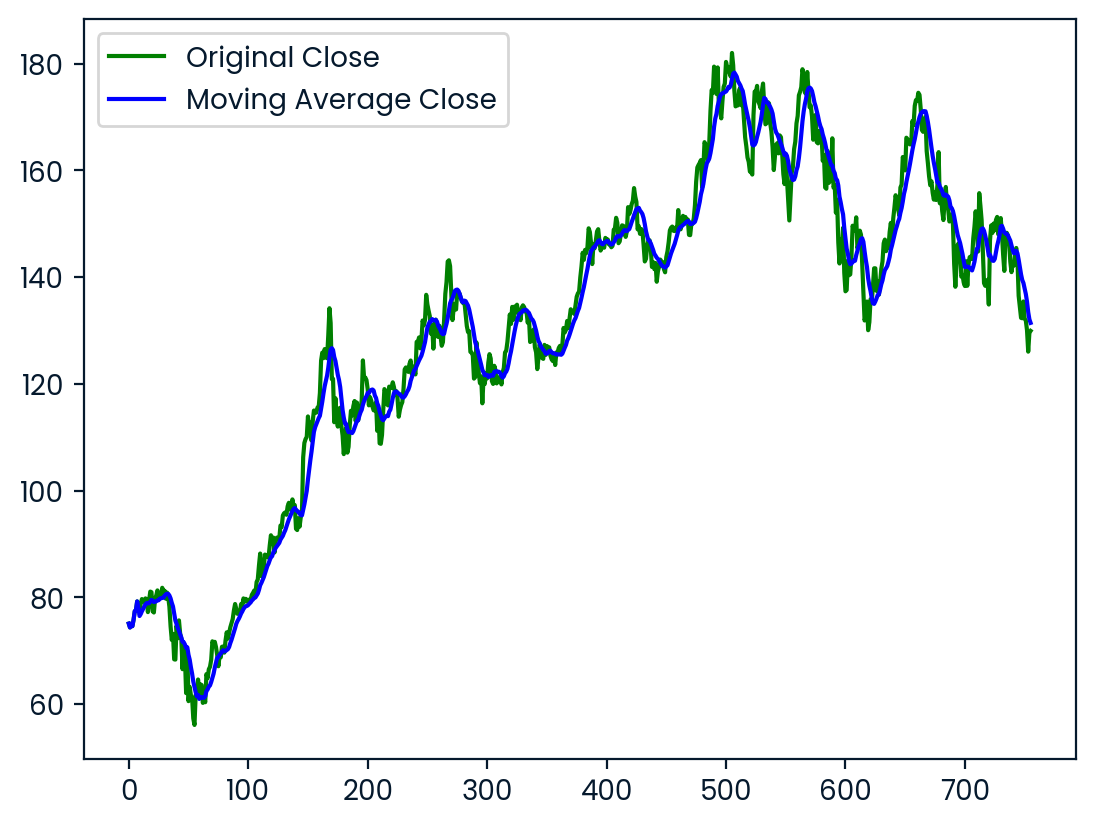

In [48]:
plt.plot(range(len(data)), data['Close'], label='Original Close', color='green')
plt.plot(range(len(data)), data['MA_10'], label='Moving Average Close', color='blue')
plt.legend()
plt.show()

In [49]:
def create_sequences(data, time_step=30):
    X, y = [], []
    for i in range(len(data) - time_step - 1):
        X.append(data[i:(i+time_step), 0])
        y.append(data[i+time_step, 0])
    return np.array(X), np.array(y)

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data[['MA_5']])

n_steps = 30 # the days lookback
X, y = create_sequences(scaled_data, N_STEPS)

X = X.reshape((X.shape[0], X.shape[1], 1))
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
X_train.shape, X_test.shape

((580, 30, 1), (145, 30, 1))

In [50]:
def evaluate_model(y_test, y_pred):
    y_pred_rescaled = scaler.inverse_transform(y_pred.reshape(-1, 1))
    rmse = sqrt(mean_squared_error(y_test, y_pred_rescaled))
    print(f'RMSE: {rmse}')
    return rmse, y_pred_rescaled

y_test_rescaled = scaler.inverse_transform(y_test.reshape(-1, 1))

In [51]:
# GRU
# Define the model building function for Keras Tuner
def build_gru_model(hp):
    model = Sequential()
    # Tune the number of units
    model.add(GRU(units=hp.Int('units', min_value=50, max_value=200, step=50), input_shape=(N_STEPS, 1)))
    model.add(Dense(1))
    
    # Tuen the learning rate or optimizer
    model.compile(optimizer=hp.Choice('optimizer', ['adam', 'rmsprop']), loss='mean_squared_error')
    return model

# Initialise the tuner
tuner_gru = kt.RandomSearch(
    build_gru_model,
    objective='val_loss',
    max_trials=10,
    executions_per_trial=1,
    directory='tuner_results_gru',
    project_name='gru_tuning'
)

# Run the search
tuner_gru.search(X_train, y_train, epochs=50, validation_data=(X_test, y_test), batch_size=32)

# Get teh optimal hyperparameters
best_hp_gru = tuner_gru.get_best_hyperparameters()[0]
print(f'Best GRU Hyperparameters:: {best_hp_gru.values}')

Reloading Tuner from tuner_results_gru/gru_tuning/tuner0.json
Best GRU Hyperparameters:: {'units': 150, 'optimizer': 'adam'}


In [52]:
best_units_gru = 150
best_optimizer_gru = 'adam'

best_gru_model = Sequential()
best_gru_model.add(GRU(best_units_gru, input_shape=(N_STEPS, 1)))
best_gru_model.add(Dense(1))
best_gru_model.compile(optimizer=best_optimizer_gru, loss='mean_squared_error')
best_gru_model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=1, validation_data=(X_test, y_test))

Epoch 1/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - loss: 0.1413 - val_loss: 0.0108
Epoch 2/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0078 - val_loss: 0.0015
Epoch 3/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0023 - val_loss: 7.7013e-04
Epoch 4/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 9.9515e-04 - val_loss: 7.2897e-04
Epoch 5/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 5.7490e-04 - val_loss: 6.8793e-04
Epoch 6/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 4.7202e-04 - val_loss: 6.6572e-04
Epoch 7/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 4.4581e-04 - val_loss: 6.8542e-04
Epoch 8/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 4.5734e-04 - val_loss: 6.9144e-04
Epoch 9/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 4.1411e-04 - val_loss: 5.4772e-04
Epoch 10/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 3.8290e-04 - val_loss: 5.2866e-04
Epoch 11/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 3.9126e-04 - val_loss: 5.0398

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
RMSE: 1.6473363049223315


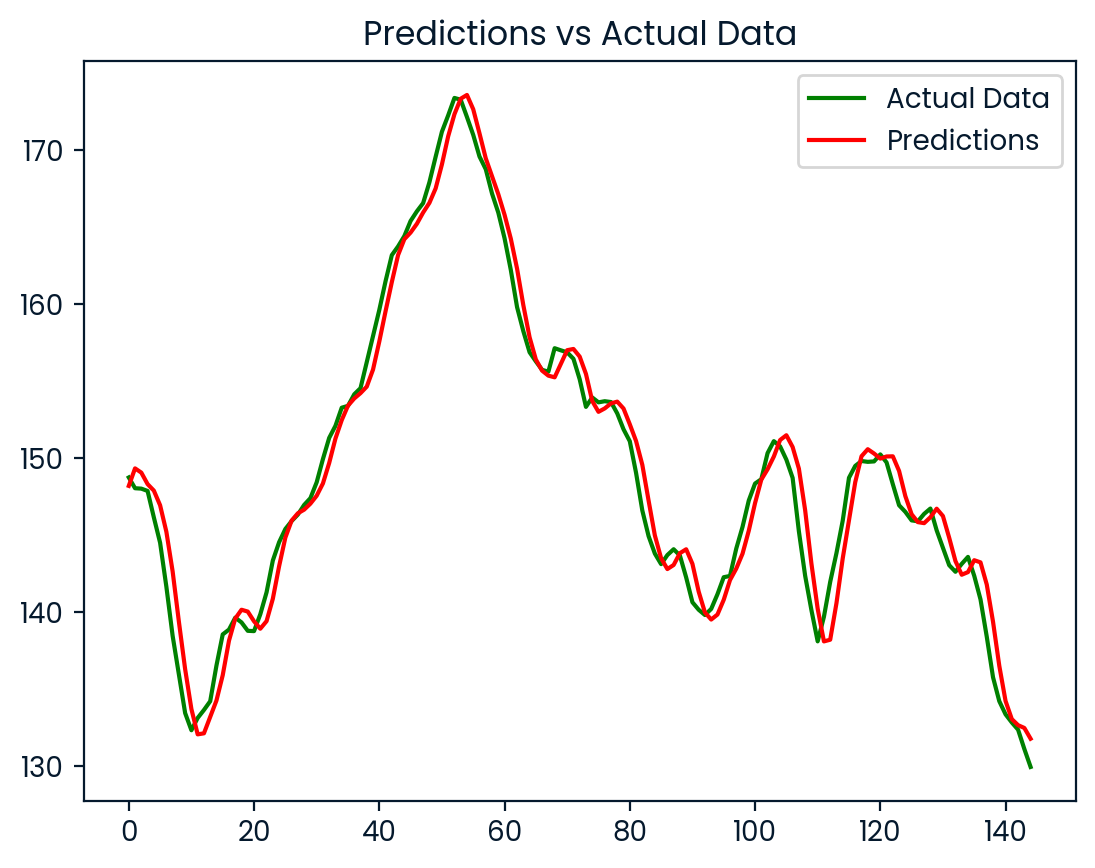

In [53]:
best_gru_predictions = best_gru_model.predict(X_test)

# Evaluate the final model
best_gru_rmse, best_gru_predictions_rescaled = evaluate_model(y_test_rescaled, best_gru_predictions)

# Plot Actual vs GRU predictions
plt.plot(y_test_rescaled, label='Actual Data', color='green')
plt.plot(best_gru_predictions_rescaled, label='Predictions', color='red')
plt.title('Predictions vs Actual Data')
plt.legend()
plt.show()